In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(style="white")

In [54]:
rating_columns = ['user_id', 'item_id', 'rating', 'timestamp']

ratings = pd.read_csv('/mnt/chromeos/MyFiles/Projects/u.data', sep='\t',names=rating_columns)

# Read first 5 rows
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [6]:
ratings.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

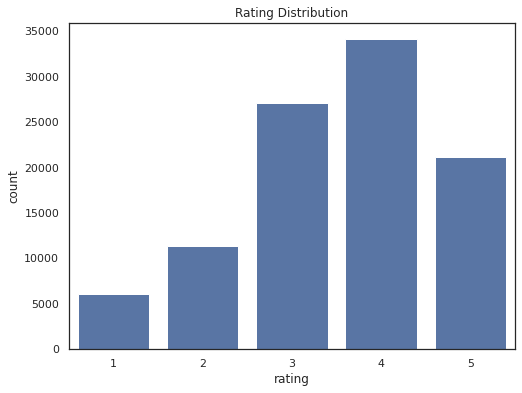

In [7]:
# Analysis of rating distribution
plt.figure(figsize=(8,6))
sns.countplot(x='rating',data=ratings)
plt.title('Rating Distribution')

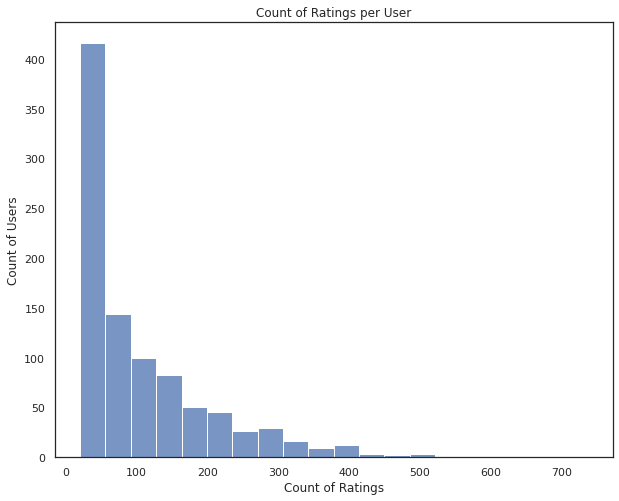

In [8]:
# Rating per user
rating_per_user=ratings.groupby('user_id').size()
plt.figure(figsize=(10,8))
sns.histplot(rating_per_user,bins=20,kde=False)
plt.title('Count of Ratings per User')
plt.xlabel('Count of Ratings')
plt.ylabel('Count of Users')
plt.show()

In [9]:
num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
total_possible_ratings = num_users * num_items
sparsity = 1 - len(ratings) / total_possible_ratings
print(f"Sparsity of the dataset: {sparsity:.2%}")


Sparsity of the dataset: 93.70%


In [10]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

In [55]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('/mnt/chromeos/MyFiles/Projects/u.item', sep='|', names=movie_columns, encoding='latin-1')

movies[['movie_id', 'title']].head()


,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')


In [13]:
# Create user-movie matrix
user_movie_matrix = data.pivot_table(index='user_id', columns='title', values='rating')


In [14]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')


In [15]:
data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')
data[['user_id', 'title', 'rating']].head()


,user_id,title,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


In [16]:
!pip uninstall scikit-surprise -y
!pip uninstall Cython -y
!pip uninstall numpy -y

Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
Found existing installation: Cython 0.29.36
Uninstalling Cython-0.29.36:
  Successfully uninstalled Cython-0.29.36
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5


In [17]:
!pip install --upgrade pip setuptools wheel
!pip install numpy==1.23.5
!pip install Cython==0.29.36


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached Cython-0.29.36-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.36-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)


In [18]:
pip install --no-binary :all: scikit-surprise

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_surprise-1.1.4-cp39-cp39-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [19]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Step 1: Load your ratings data
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# Step 2: Split into train and test set
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Step 3: Use SVD (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

# Step 4: Predict ratings on the test set
predictions = model.test(testset)

# Step 5: Evaluate the model
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))



RMSE: 0.9356
RMSE: 0.9355899213979668
MAE:  0.7384
MAE: 0.7384077670970075


In [20]:
print(f"Number of training ratings: {trainset.n_ratings}")
print(f"Number of test ratings: {len(testset)}")

Number of training ratings: 80000
Number of test ratings: 20000


In [21]:
# Filter users with more than 100 ratings
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts > 100].index
filtered_data = data[data['user_id'].isin(active_users)]

# Filter movies with more than 50 ratings
movie_counts = filtered_data['title'].value_counts()
popular_movies = movie_counts[movie_counts > 50].index
filtered_data = filtered_data[filtered_data['title'].isin(popular_movies)]


In [22]:
filtered_matrix = filtered_data.pivot_table(index='user_id', columns='title', values='rating')


In [23]:
# Choose your target movie
target_movie = 'Star Wars (1977)'

# Check if the movie exists in your filtered matrix
if target_movie in filtered_matrix.columns:
    # Get all the user ratings for this movie
    movie_ratings = filtered_matrix[target_movie]
    
    # Compute correlations between 'Star Wars (1977)' and every other movie
    similar_movies = filtered_matrix.corrwith(movie_ratings)
    
    # Create a DataFrame for easy sorting and filtering
    corr_df = similar_movies.to_frame(name='Correlation').dropna()
    
    # Add the number of ratings for each movie for reliability
    rating_counts = filtered_data.groupby('title')['rating'].count()
    corr_df = corr_df.join(rating_counts)
    
    # Filter for movies with a minimum number of ratings, then sort by correlation
    recommendations = corr_df[corr_df['rating'] > 50].sort_values('Correlation', ascending=False)
    
    print("Top recommendations based on 'Star Wars (1977)':")
    print(recommendations.head(10))
else:
    print(f"'{target_movie}' not found in the filtered matrix.")


Top recommendations based on 'Star Wars (1977)':
                                                    Correlation  rating
title                                                                  
Star Wars (1977)                                       1.000000     328
Empire Strikes Back, The (1980)                        0.734640     271
Return of the Jedi (1983)                              0.682426     301
Raiders of the Lost Ark (1981)                         0.494209     306
Things to Do in Denver when You're Dead (1995)         0.395455      54
Frighteners, The (1996)                                0.393774      87
Austin Powers: International Man of Mystery (1997)     0.391133      94
Spitfire Grill, The (1996)                             0.360801      57
L.A. Confidential (1997)                               0.360655     121
Sting, The (1973)                                      0.360203     178


In [56]:
from surprise import Dataset, Reader
# Define the rating scale; for MovieLens, it's typically 1 to 5
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)


TypeError: 'DatasetAutoFolds' object is not subscriptable

In [57]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)


In [58]:
from surprise import SVD
model = SVD()
model.fit(trainset)


In [27]:
from surprise import accuracy
predictions = model.test(testset)
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))


RMSE: 0.9401
RMSE: 0.940071375872125
MAE:  0.7409
MAE: 0.7409319053372557


In [28]:
!pip install streamlit

Defaulting to user installation because normal site-packages is not writeable


In [68]:
import streamlit as st

# Streamlit app title
st.title("Movie Recommender")

# Dropdown to choose a movie
movie = st.selectbox("Select a movie", filtered_matrix.columns.tolist())

if st.button("Show Recommendations"):
    movie_ratings = filtered_matrix[movie]

    # Calculate correlation
    similar_movies = filtered_matrix.corrwith(movie_ratings)
    corr_df = similar_movies.to_frame(name='Correlation').dropna()

    # Add number of ratings
    rating_counts = filtered_data.groupby('title')['rating'].count()
    corr_df = corr_df.join(rating_counts.rename("Rating Count"))

    # Filter and sort
    recommendations = corr_df[corr_df['Rating Count'] > 50].sort_values('Correlation', ascending=False)

    # Display top 10 similar movies
    st.subheader("Top Similar Movies:")
    for title, row in recommendations.head(10).iterrows():
        st.write(f"{title} (Similarity: {row['Correlation']:.2f})")



2025-06-17 19:29:30.961 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:30.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 19:29:31.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [30]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 
                 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
                 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                 'War', 'Western']

movies = pd.read_csv('/mnt/chromeos/MyFiles/Projects/u.item', sep='|', names=movie_columns, encoding='latin-1')


In [31]:
ratings = pd.merge(ratings, movies[['movie_id', 'title']], left_on='item_id', right_on='movie_id')


In [32]:
ratings['title'].value_counts().head(10)


title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

In [33]:
ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)


title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

In [34]:
user_movie_matrix = ratings.pivot_table(index='user_id', columns='title', values='rating')


In [35]:
movie_ratings = user_movie_matrix['Star Wars (1977)']


In [36]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
similar_to_starwars = user_movie_matrix.corrwith(movie_ratings)


In [37]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)


In [38]:
movie_stats = ratings.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['Average Rating', 'Rating Count']

corr_starwars = corr_starwars.join(movie_stats['Rating Count'])


In [39]:
recommendations = corr_starwars[corr_starwars['Rating Count'] > 100].sort_values('Correlation', ascending=False)
recommendations.head(10)


,Correlation,Rating Count
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [40]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_movie_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


In [44]:
!pip install scikit-surprise


Defaulting to user installation because normal site-packages is not writeable


In [45]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'title', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)


In [46]:
from surprise import accuracy

rmse = accuracy.rmse(predictions)


RMSE: 0.9389


In [47]:
import pickle

pickle.dump(user_movie_matrix, open("user_movie_matrix.pkl", "wb"))
pickle.dump(recommendations, open("recommendations.pkl", "wb"))


In [48]:
import streamlit as st

st.title("Movie Recommender")

movie_name = st.selectbox("Choose a movie:", user_movie_matrix.columns)
st.write("Top similar movies:")
st.write(recommendations[movie_name].head(10))


2025-06-17 18:56:01.948 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.950 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.952 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-17 18:56:01.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

KeyError: "'Til There Was You (1997)"

In [ ]:
streamlit run recommender_app.py


In [ ]:
print(recommendations.shape)
print(recommendations.columns[:5])
print(recommendations.index[:5])



In [ ]:
# Option 2: A similarity matrix with all titles as both rows and columns
recommendations.loc["Star Wars (1977)"].sort_values(ascending=False).head(10)


In [ ]:
print("101 Dalmatians (1996)" in recommendations.index)


In [ ]:
# Compute Pearson correlation between movies
movie_similarity = user_movie_matrix.corr(method='pearson')


In [ ]:
recommendations_dict = {}

for movie in movie_similarity.columns:
    try:
        similar_scores = movie_similarity[movie].dropna()
        
        # Drop self only if present
        if movie in similar_scores.index:
            similar_scores = similar_scores.drop(labels=[movie])
        
        # Sort and keep top 10
        top_similars = similar_scores.sort_values(ascending=False).head(10)
        
        recommendations_dict[movie] = list(top_similars.items())
        
    except KeyError:
        # Movie not found in similarity matrix (can skip it)
        continue


In [ ]:
import pickle
with open("recommendations.pkl", "wb") as f:
    pickle.dump(recommendations_dict, f)


In [ ]:
print(recommendations["Star Wars (1977)"])


In [49]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

reader  = Reader(rating_scale=(1,5))
data    = Dataset.load_from_df(ratings[['user_id','item_id','rating']], reader)
train , test = train_test_split(data, test_size=.2, random_state=42)

algo    = SVD(n_factors=50, random_state=42)
algo.fit(train)
preds   = algo.test(test)
rmse    = accuracy.rmse(preds)   # prints & returns RMSE


RMSE: 0.9348
